In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
BASE_DIR = os.getcwd()
csv_path = os.path.join(BASE_DIR, "mtg-trimmed-1.csv")
clean_csv_path = os.path.join(BASE_DIR, "mtg-01.csv")
pd.set_option("display.max_columns", None)

In [3]:
df = pd.read_csv(csv_path)

In [4]:
df

,name,mana_cost,cmc,type_line,power,toughness,colors,color_identity,produced_mana
0,Fury Sliver,{5}{R},6.0,Creature — Sliver,3,3,['R'],['R'],NaN
1,Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,2,2,['W'],['W'],NaN
2,Spirit,NaN,0.0,Token Creature — Spirit,1,1,['W'],['W'],NaN
3,Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,1,2,['U'],['U'],NaN
4,Web,{G},1.0,Enchantment — Aura,NaN,NaN,['G'],['G'],NaN
...,...,...,...,...,...,...,...,...,...
61639,Angel's Tomb,{3},3.0,Artifact,NaN,NaN,[],[],NaN
61640,Boomerang,{U}{U},2.0,Instant,NaN,NaN,['U'],['U'],NaN
61641,Celestine Reef,NaN,0.0,Plane — Luvion,NaN,NaN,[],[],NaN
61642,Horned Troll,{2}{G},3.0,Creature — Troll,2,2,['G'],['G'],NaN


## Feature Engineering

#### Plot all missing values

<AxesSubplot:title={'center':'Examine missing values'}>

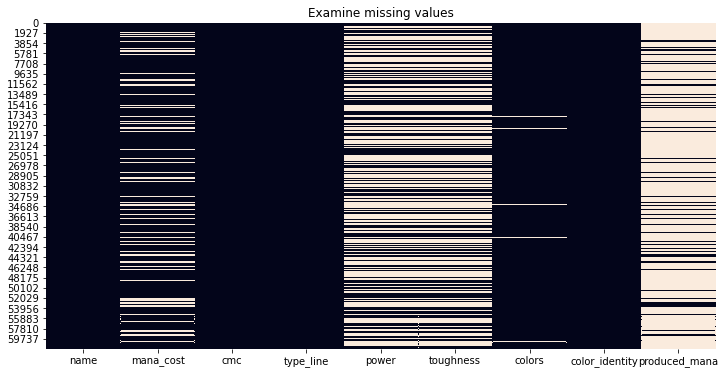

In [5]:
plt.figure(figsize=(12, 6))
plt.title("Examine missing values")
sns.heatmap(df.isnull(), cbar=False)

#### We only need cards with actual "power" and "toughness" numerical values

In [6]:
print("Number of missing values in:")
print(df.loc[:, ['power', 'toughness']].isna().sum())

Number of missing values in:
power        33129
toughness    33129
dtype: int64


In [7]:
# Maybe like that
# pattern = r'([0-9]*[.]?[0-9]+)'
df['power'] = df['power'].str.extract(r'([0-9]*[.]?[0-9]+)')
df['toughness'] = df['toughness'].str.extract(r'([0-9]*[.]?[0-9]+)')

In [8]:
df = df[df['power'].notna()]
df = df[df['toughness'].notna()]

In [9]:
df.isna().sum()

name                  0
mana_cost          1169
cmc                   0
type_line             0
power                 0
toughness             0
colors                0
color_identity        0
produced_mana     27095
dtype: int64

#### There's too many missing values in "produced_mana" to keep this column. I suspect that very few cards that can attack, also produce mana, so I'll consider them unnecessary.

In [10]:
df.drop(columns='produced_mana', inplace=True)

#### Convert dtypes

In [11]:
df[['power', 'toughness']] = df[['power', 'toughness']].astype(float)

#### Create "type" column

In [12]:
def make_list(row):
    return row.replace('—', ',').split(',')

df['type_line'] = df['type_line'].apply(lambda x: make_list(x))
df['type'] = df['type_line'].apply(lambda x: x[0])

#### Mapping values to 0 (below mean) and 1 (above)

In [13]:
# Mapping "power"
df.loc[df['power'] <= 2.5, 'power'] = 0
df.loc[df['power'] > 2.5, 'power'] = 1

# Mapping "toughness"
df.loc[df['toughness'] <= 2.5, 'toughness'] = 0
df.loc[df['toughness'] > 2.5, 'toughness'] = 1

#### Mapping "Creature" type to 0 and any other type to 1

In [14]:
# Mapping "type"
def creature(string):
    if string.startswith("C"):
        return 0
    return 1

df['type'] = df['type'].apply(lambda x: creature(x))

In [15]:
# TO-DO MAYBE (GET TYPE_2)
# df['type_2'] = df['type_line'].apply(lambda x: x[1])

#### Since "cmc" is just a sum of values from "mana_cost", without specified mana color, I will keep only "cmc". Also, I will drop "colors" column, because is seems to be very similar to "color_identity". Finally, I'll drop "name" and "type_line".

In [16]:
df.drop(columns=['name', 'mana_cost', 'type_line', 'colors'], inplace=True)
df.rename(columns={'color_identity': 'color'}, inplace=True)

#### Adjust "color" values

In [17]:
df.shape

(27996, 5)

In [18]:
def color(letters):
    if len(letters) < 3:
        return np.nan
    return letters[2]

In [19]:
df['color'] = df['color'].apply(lambda x: color(x))

In [20]:
df.reset_index(drop=True, inplace=True)

In [21]:
df.loc[df['color'] == "R", 'color'] = 0 # start from 1?
df.loc[df['color'] == "W", 'color'] = 1
df.loc[df['color'] == "U", 'color'] = 2
df.loc[df['color'] == "G", 'color'] = 3
df.loc[df['color'] == "B", 'color'] = 4

In [22]:
df.isna().sum()

cmc             0
power           0
toughness       0
color        1595
type            0
dtype: int64

#### This generated some missing values, let's fill them

In [23]:
df.fillna(method='bfill', inplace=True)

In [29]:
df['color'].isna().sum()

0

In [25]:
df.to_csv(clean_csv_path, index=False)